In [103]:
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
from pathlib import Path

#function for showing volume images
def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [4]:
data = pd.read_csv('C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/survival_data.csv')
data.head(10)

,BraTS18ID,Age,Survival,ResectionStatus
0,Brats18_TCIA08_167_1,74.907,153,NaN
1,Brats18_TCIA08_242_1,66.479,147,NaN
2,Brats18_TCIA08_319_1,64.860,254,NaN
3,Brats18_TCIA08_469_1,63.899,519,NaN
4,Brats18_TCIA08_218_1,57.345,346,NaN
5,Brats18_TCIA08_406_1,78.745,82,NaN
6,Brats18_TCIA08_280_1,57.362,508,NaN
7,Brats18_TCIA08_105_1,66.627,77,NaN
8,Brats18_TCIA08_278_1,50.501,1458,NaN
9,Brats18_TCIA06_247_1,76.699,244,NaN


In [30]:
data.loc[data['BraTS18ID']=='Brats18_2013_10_1']

,BraTS18ID,Age,Survival,ResectionStatus


In [5]:
#making separate directories for different modalities in order
path = 'C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/'
path_HGG = 'C://Image Processing/brats data/new/HGG/'
path_LGG = 'C://Image Processing/brats data/new/LGG/'
list_of_dirs = ['t1','T1Gd','t2','flair']

def make_my_dirs(directory, names):
    for i in names: 
        os.makedirs(directory+i, exist_ok = True)

make_my_dirs(path_HGG, list_of_dirs)
make_my_dirs(path_LGG, list_of_dirs)

In [39]:
#creating lists with images of different modalities

common_list = []
t2_list = []
t1_list = []
t1ce_list = []
flair_list = []
seg_list = []
for (dirpath, dirnames, filenames) in os.walk('C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/'):
    for filename in filenames: 
        if filename.endswith('.csv')==False and 'seg' not in filename.split('.')[0]:
            common_list.append(os.path.join(dirpath,filename))
            if 't2' in filename.split('.')[0]: 
                t2_list.append(os.path.join(dirpath,filename))
            if 't1' in filename.split('.')[0] and 't1ce' not in filename.split('.')[0]:
                t1_list.append(os.path.join(dirpath,filename))
            if 't1ce' in filename.split('.')[0]:
                t1ce_list.append(os.path.join(dirpath,filename))
            if 'flair' in filename.split('.')[0]:
                flair_list.append(os.path.join(dirpath,filename))
        if 'seg' in filename.split('.')[0]:
            seg_list.append(os.path.join(dirpath,filename))

In [51]:
#All of Modalities` paths into one dataframe for further processing

paths_data=pd.DataFrame(np.column_stack([t1_list,t1ce_list,t2_list,flair_list,seg_list]),
                       columns=['t1_p','t1ce_p','t2_p','flair_p','seg_p'])

pd.set_option('display.max_colwidth', -1)
paths_data.loc[222,:]

t1_p       C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t1.nii.gz   
t1ce_p     C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t1ce.nii.gz 
t2_p       C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t2.nii.gz   
flair_p    C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_flair.nii.gz
seg_p      C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_seg.nii.gz  
Name: 222, dtype: object

In [99]:
len(t1_list)
len(seg_list)

285

In [31]:
def plot_spacing(l):
    ''' 

    this function helps to plot spacing histograms 
    
    l = list with files` paths 


    '''    
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSpacing())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Pixel Spacing (x,y,z)',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('pixel spacing (x,y,z) in mm',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()



def plot_size(l):
    '''
    this function helps to plot size histograms 
    
    l = list with files` paths
    '''
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSize())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Size',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('Size ',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()

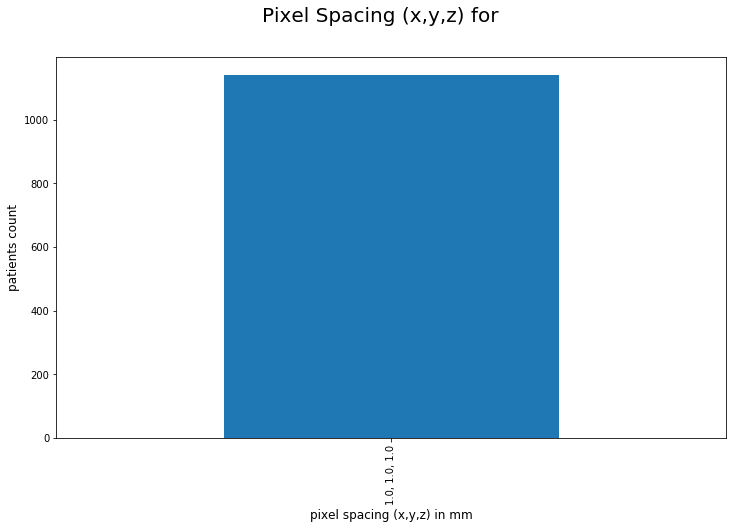

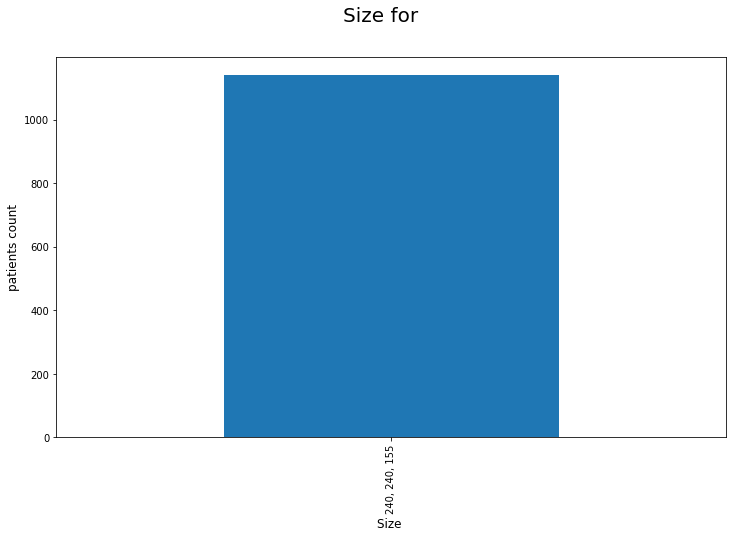

In [32]:
plot_spacing(common_list)
plot_size(common_list)

In [80]:

def getMinMax( img):
    mm = sitk.MinimumMaximumImageFilter()
    mm.Execute(img)
    return (mm.GetMinimum(), mm.GetMaximum())

def getStatistic(img):
    image_statistic = sitk.StatisticsImageFilter()
    statistic = image_statistic.Execute(img)
    return statistic



mm = sitk.MinimumMaximumImageFilter()
mm.Execute(im1)
a = mm.GetMinimum()
b = mm.GetMaximum()

image_statistic = sitk.StatisticsImageFilter()
image_statistic.Execute(im1)

val = getMinMax(im1)
c =[]
for i in val:
    c.append(i)
c_min=min(c)



0.0

In [ ]:
def plot_size(l):
    '''
    this function helps to plot size histograms 
    
    l = list with files` paths
    '''
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSize())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Size',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('Size ',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()

In [81]:
#For further processing we should plot Intensity Ranges
#Necessary because if it is differ we should normilize them

def plot_intensities(l,how='counts'):
    #plot intensity ranges 
    
    #l= path for the images
    
    #'counts' = plots all intensity ranges among all images
    #'min/max' = plots min and max values among all images
    mm = sitk.MinimumMaximumImageFilter() #takes minimum and maximum intensity values from image
    temp_list_counts = []
    min_max_list = []
    
    def getMinMax(img):
        #Function that takes minimum and maximum value from one image
        mm = sitk.MinimumMaximumImageFilter()
        mm.Execute(img)
        return (mm.GetMinimum(), mm.GetMaximum())
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value = getMinMax(image_read)
        temp_list_counts.append(str(value).strip('()'))
        for i in value:
            min_max_list.append(i)
    temp_df_counts=pd.DataFrame(temp_list_counts)
    
    if how=='counts':
    
        plt.figure(figsize=(12,7))
        plt.suptitle('Intensity Range', fontsize=20)
        ax=temp_df_counts[0].value_counts().plot(kind='bar')
        ax.set_xlabel('Intensities', fontsize='large')
        ax.set_ylabel('Counts',fontsize='large')
        plt.show()
    
    if how=='min/max':
        print('the minimum intesity value is:\t{}\nthe maximum intensity value is:\t{}'.format(min(min_max_list), max(min_max_list)))

In [83]:
plot_intensities(common_list, how='min/max')

the minimum intesity value is:	0.0
the maximum intensity value is:	32767.0


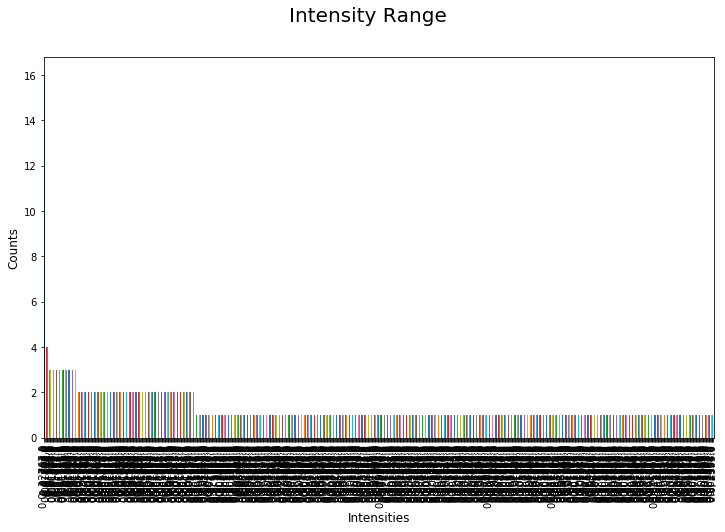

In [100]:
plot_intensities(common_list)

# Normalization to [-127,127] scale range 

In [139]:
#Linear Function Normalization

def norm_all(l):
    #set intensity scale to the range of [-127,127]
    imadjust = sitk.RescaleIntensityImageFilter()
    imadjust.SetOutputMinimum( -127 )
    imadjust.SetOutputMaximum( 127 )    
    for image in l: 
        im=sitk.ReadImage(i)
        norm_im=imadjust.Execute( im )
        name =  i.split('\\')[-1]
        sitk.WriteImage(norm_im, image)

        
        
norm_all(common_list) #applying         

In [140]:
plot_intensities(common_list, how='min/max')

the minimum intesity value is:	-127.0
the maximum intensity value is:	127.0


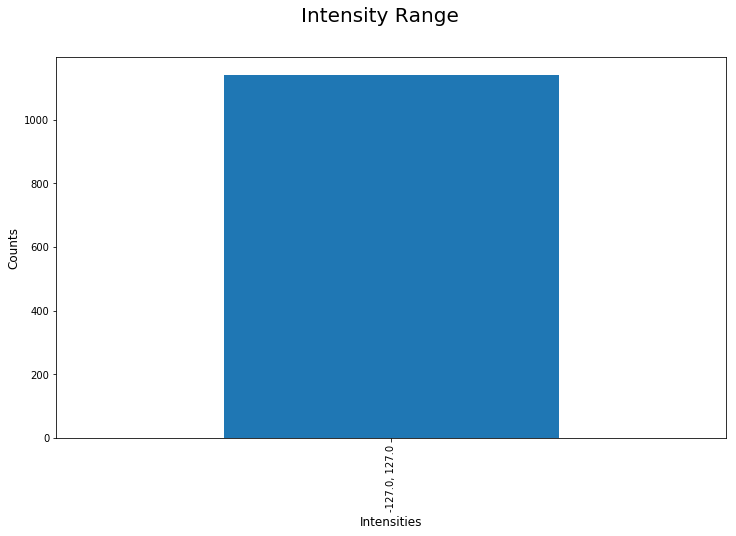

In [141]:
plot_intensities(common_list)

In [107]:
#linear normalization to the range [-127,127]

imadjust = sitk.RescaleIntensityImageFilter()
imadjust.SetOutputMinimum( -127 )
imadjust.SetOutputMaximum( 127 )
norm = imadjust.Execute( im1 )   

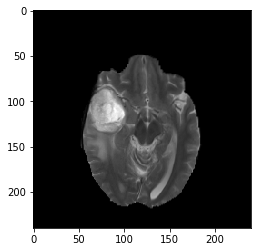

In [108]:
norm_arr = sitk.GetArrayFromImage( norm )
myshow(norm_arr, 62)

In [106]:
hist,bins = np.histogram(img.flatten(),256,[0,256])
 
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
 
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000001ED4D307E70> >

In [116]:
 def getMinMax(img):
        #Function that takes minimum and maximum value from one image
        mm = sitk.MinimumMaximumImageFilter()
        mm.Execute(img)
        return (mm.GetMinimum(), mm.GetMaximum())
    
norm_val = getMinMax(norm)

val = getMinMax(im1)

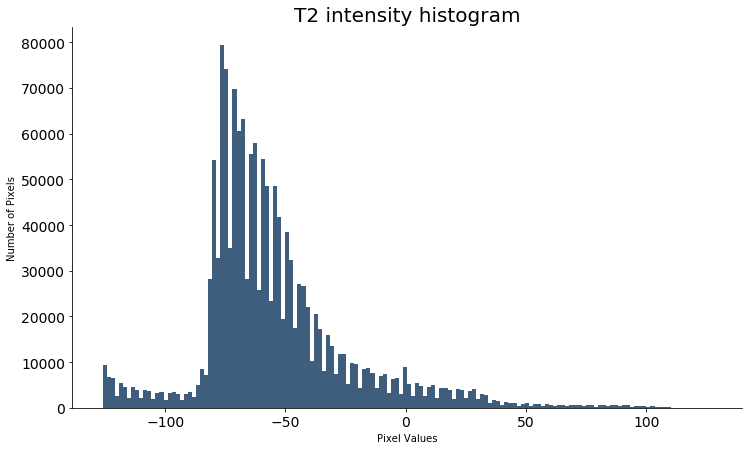

In [131]:
#t2 intensity histmogram

plt.figure(figsize=(12,7))

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title('T2 intensity histogram', fontsize=20)

plt.hist(norm_arr.ravel(),range=[-126,127],bins=150, histtype='bar',color="#3F5D7D")
plt.xlabel('Pixel Values')
plt.ylabel('Number of Pixels')
plt.show()

In [105]:
#lists of paths for all modalities
im1 = sitk.ReadImage(t2_list[0])
im_arr_1 = sitk.GetArrayFromImage(im1)

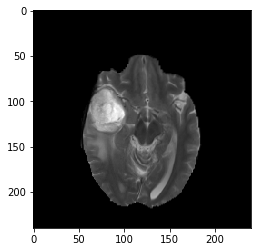

In [192]:
sl_62 = im_arr_1[62,:,:]
#myshow(im_arr_1, 62)
plt.imshow(sl_62,cmap = 'gray')

sl_62 = sitk.GetImageFromArray(sl_62)

In [193]:
type(sl_62)

SimpleITK.SimpleITK.Image

In [195]:
sl_62.GetOrigin()

(0.0, 0.0)

In [204]:
coordinates = [17, 11]

extract = sitk.ExtractImageFilter()
extract.SetSize([32,32])
extract.SetIndex([75-16,100-16])
extracted_image = extract.Execute(sl_62)


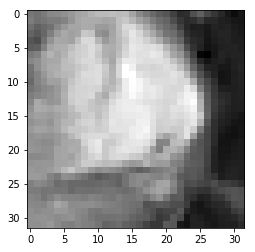

In [205]:
extrcated_rr = sitk.GetArrayFromImage(extracted_image)

plt.imshow(extrcated_rr, cmap = 'gray')